In [1]:
# Impor tensorflow and numpy
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import math as m
import time
# For validation
from sklearn.metrics import confusion_matrix
import itertools



# For plotting
from matplotlib import pyplot as plt

# Add the library to the system path
import os,sys
se2cnn_source =  os.path.join(os.getcwd(),'..')
if se2cnn_source not in sys.path:
    sys.path.append(se2cnn_source)

# Import the library
import se2cnn.layers

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# check tf can see the GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1523519337201949708
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9848225792
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4721537981234494761
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:06:00.0, compute capability: 8.9"
]


In [3]:
# Xavier's/He-Rang-Zhen-Sun initialization for layers that are followed ReLU
def weight_initializer(n_in, n_out):
    return tf.random_normal_initializer(mean=0.0, stddev=m.sqrt(2.0 / (n_in))
    )

def size_of(tensor) :
    # Multiply elements one by one
    result = 1
    for x in tensor.get_shape().as_list():
         result = result * x 
    return result 

## Load and Format Dataset

In [4]:
code_distance = 7

error_rate = 0.1

observations = 70000

dataset = np.load(f'test-datasets/HL_data_{code_distance}_{int(error_rate*100)}_{observations}.npy')

non_test, test = np.split(dataset, [60000])

non_test_data = non_test[:, :code_distance**2 *2]
# last 4 columns are the labels
nontest_labels= non_test[:, -4:]

test_data = test[:, :code_distance**2 *2]
test_labels= test[:, -4:]

# Reshape to 2D multi-channel images
nontest_data_2D = non_test_data.reshape(len(non_test_data), code_distance, code_distance*2,1) # data shape here
test_data_2D = test_data.reshape(len(test_data), code_distance, code_distance*2,1)

print(f"nontest_data_2D.shape = {nontest_data_2D.shape}")


nontest_data_2D.shape = (60000, 7, 14, 1)


In [5]:
# pad data #todo: make this reflect closed surfacec

nontest_data_2D = np.pad(nontest_data_2D,((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=((0,0),(0,0),(0,0),(0,0)))
test_data_2D = np.pad(test_data_2D,((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=((0,0),(0,0),(0,0),(0,0)))

print(nontest_data_2D.shape, test_data_2D.shape)

(60000, 11, 18, 1) (10000, 11, 18, 1)


distance: 7


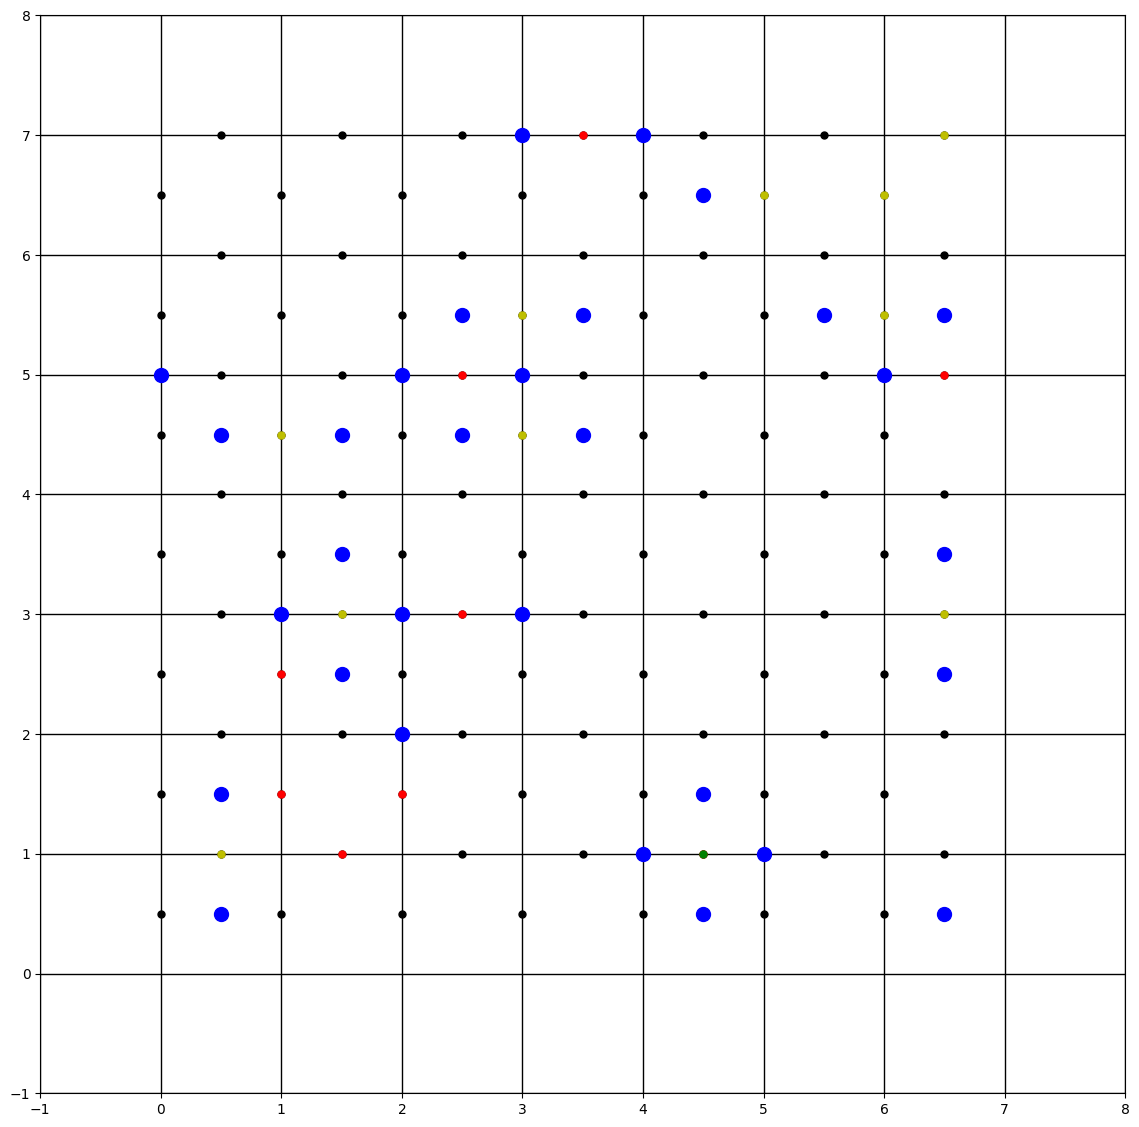

[0 0 0 0]


In [6]:
from Datavis import visualize_observation

# visualizing observation and label
# red: x-error, yellow: z-error, green: x and z error, blue: stabilizer activation

observation_index = 69

visualize_observation(non_test[observation_index][:-4])
print(non_test[observation_index][-4:])


# one-hot encode all labels

In [7]:
from scipy.sparse import eye
imat = eye(16).toarray()
# convert to integer matrix
imat = imat.astype(int)

encoding_dict = {}
for i in range(0,16):
    # convert to numpy array
    encoding_dict[i] = np.array(imat[15-i])

# do that for all entries in nontest_labels
nontest_labels_encoded = np.argmax(np.array([encoding_dict[int(''.join(map(str,single_label)),2)] for single_label in nontest_labels]), axis=1)


test_labels_encoded = np.argmax(np.array([encoding_dict[int(''.join(map(str,single_label)),2)] for single_label in test_labels]), axis=1)




## Define GCNN Structure

In [8]:
Ntheta = 4 # Kernel size in angular direction
Nxy = 3      # Kernel size in spatial direction
Nc = 8      # Number of channels in the initial layer

graph = tf.Graph()
graph.as_default()
tf.compat.v1.reset_default_graph()

inputs_ph = tf.placeholder( dtype = tf.float32, shape = [None, code_distance + 4, 2*code_distance + 4, 1] ) # data shape here
labels_ph = tf.placeholder( dtype = tf.int32, shape = [None,] )

print(inputs_ph.shape)
print(labels_ph.shape)

tensor_in = inputs_ph
Nc_in = 1

kernels={}


(?, 11, 18, 1)
(?,)


### Layer 1

In [9]:
with tf.variable_scope("Layer_{}".format(1)) as _scope:
    ## Settings
    Nc_out = Nc

    ## Perform lifting convolution
    # The kernels used in the lifting layer
    kernels_raw = tf.get_variable(
                        'kernel', 
                        [Nxy,Nxy,Nc_in,Nc_out],
                        initializer=weight_initializer(Nxy*Nxy*Nc_in,Nc_out))
    tf.add_to_collection('raw_kernels', kernels_raw)
    bias = tf.get_variable( # Same bias for all orientations
                        "bias",
                        [1, 1, 1, 1, Nc_out], 
                        initializer=tf.constant_initializer(value=0.01))
    # Lifting layer
    tensor_out, kernels_formatted = se2cnn.layers.z2_se2n(
                            input_tensor = tensor_in,
                            kernel = kernels_raw,
                            orientations_nb = Ntheta)
    # Add bias
    tensor_out = tensor_out + bias
    
    ## Apply ReLU
    tensor_out = tf.nn.relu(tensor_out)

    ## Prepare for the next layer
    tensor_in = tensor_out
    Nc_in = Nc_out
    
    ## Save kernels for inspection
    kernels[_scope.name] = kernels_formatted

Z2-SE2N BASE KERNEL SHAPE: (3, 3, 1, 8)
Z2-SE2N ROTATED KERNEL SET SHAPE: (4, 3, 3, 1, 8)
OUTPUT SE2N ACTIVATIONS SHAPE: (?, 9, 16, 4, 8)


In [10]:
print(tensor_in.get_shape())

(?, 9, 16, 4, 8)


### Layer 2

In [11]:
with tf.variable_scope("Layer_{}".format(2)) as _scope:
    ## Settings
    Nc_out = 2*Nc

    ## Perform group convolution
    # The kernels used in the group convolution layer
    kernels_raw = tf.get_variable(
                        'kernel', 
                        [Nxy,Nxy,Ntheta,Nc_in,Nc_out],
                        initializer=weight_initializer(Nxy*Nxy*Ntheta*Nc_in,Nc_out))
    tf.add_to_collection('raw_kernels', kernels_raw)
    bias = tf.get_variable( # Same bias for all orientations
                        "bias",
                        [1, 1, 1, 1, Nc_out], 
                        initializer=tf.constant_initializer(value=0.01))
    # The group convolution layer
    tensor_out, kernels_formatted = se2cnn.layers.se2n_se2n(
                            input_tensor = tensor_in,
                            kernel = kernels_raw)
    tensor_out = tensor_out + bias

    
    ## Apply ReLU
    tensor_out = tf.nn.relu(tensor_out)

    ## Prepare for the next layer
    tensor_in = tensor_out
    Nc_in = Nc_out
    
    ## Save kernels for inspection
    kernels[_scope.name] = kernels_formatted

SE2N-SE2N BASE KERNEL SHAPE: (3, 3, 4, 8, 16)
SE2N-SE2N ROTATED KERNEL SET SHAPE: (4, 3, 3, 4, 8, 16)
OUTPUT SE2N ACTIVATIONS SHAPE: (?, 7, 14, 4, 16)


### Layer 3

In [12]:
# 2D convolution layer
with tf.variable_scope("Layer_{}".format(3)) as _scope:
    ## Settings
    Nc_out = 4*Nc

    ## Perform group convolution
    # The kernels used in the group convolution layer
    kernels_raw = tf.get_variable(
                        'kernel', 
                        [Nxy,Nxy,Ntheta,Nc_in,Nc_out],
                        initializer=weight_initializer(Nxy*Nxy*Ntheta*Nc_in,Nc_out))
    tf.add_to_collection('raw_kernels', kernels_raw)
    bias = tf.get_variable( # Same bias for all orientations
                        "bias",
                        [1, 1, 1, 1, Nc_out], 
                        initializer=tf.constant_initializer(value=0.01))
    # The group convolution layer
    tensor_out, kernels_formatted = se2cnn.layers.se2n_se2n(
                            input_tensor = tensor_in,
                            kernel = kernels_raw)
    tensor_out = tensor_out + bias
    
    ## Apply ReLU
    tensor_out = tf.nn.relu(tensor_out)

    ## Prepare for the next layer
    tensor_in = tensor_out
    Nc_in = Nc_out
    
    ## Save kernels for inspection
    kernels[_scope.name] = kernels_formatted

SE2N-SE2N BASE KERNEL SHAPE: (3, 3, 4, 16, 32)
SE2N-SE2N ROTATED KERNEL SET SHAPE: (4, 3, 3, 4, 16, 32)
OUTPUT SE2N ACTIVATIONS SHAPE: (?, 5, 12, 4, 32)


### Layer 4

In [13]:
# 2D convolution layer
with tf.variable_scope("Layer_{}".format(4)) as _scope:
    ## Settings
    Nc_out = 128

    ## Perform group convolution
    # The kernels used in the group convolution layer
    kernels_raw = tf.get_variable(
                        'kernel', 
                        [Nxy,Nxy,Ntheta,Nc_in,Nc_out],
                        initializer=weight_initializer(Nxy*Nxy*Ntheta*Nc_in,Nc_out))
    tf.add_to_collection('raw_kernels', kernels_raw)
    bias = tf.get_variable( # Same bias for all orientations
                        "bias",
                        [1, 1, 1, 1, Nc_out], 
                        initializer=tf.constant_initializer(value=0.01))
    # Convolution layer
    # The group convolution layer
    tensor_out, kernels_formatted = se2cnn.layers.se2n_se2n(
                            input_tensor = tensor_in,
                            kernel = kernels_raw)
    tensor_out = tensor_out + bias
    
    ## Apply ReLU
    tensor_out = tf.nn.relu(tensor_out)

    ## Prepare for the next layer
    tensor_in = tensor_out
    Nc_in = Nc_out
    
    ## Save kernels for inspection
    kernels[_scope.name] = kernels_formatted

SE2N-SE2N BASE KERNEL SHAPE: (3, 3, 4, 32, 128)
SE2N-SE2N ROTATED KERNEL SET SHAPE: (4, 3, 3, 4, 32, 128)
OUTPUT SE2N ACTIVATIONS SHAPE: (?, 3, 10, 4, 128)


In [14]:
tensor_in.get_shape()

TensorShape([Dimension(None), Dimension(3), Dimension(10), Dimension(4), Dimension(128)])

### Layer 5

In [15]:
with tf.variable_scope("Layer_{}".format(5)) as _scope:
    ## Settings
    Nc_out = 16

    ## Perform group convolution
    # The kernels used in the group convolution layer
    kernels_raw = tf.get_variable(
                        'kernel', 
                        [1,1,Nc_in,Nc_out],
                        initializer=weight_initializer(1*1*Nc_in,Nc_out))
    tf.add_to_collection('raw_kernels', kernels_raw)
    bias = tf.get_variable( # Same bias for all orientations
                        "bias",
                        [1, 1, 1, Nc_out], 
                        initializer=tf.constant_initializer(value=0.01))

    
    ## Convolution layer
    tensor_out = tf.nn.conv2d(
                        input = tensor_in,
                        filter=kernels_raw,
                        strides=[1, 1, 1, 1],
                        padding="VALID")
    tensor_out = tensor_out + bias

    tensor_out= tf.reduce_max(tensor_out, axis=1)
    
    ## The output logits
    logits = tensor_out[:,0,0,:]
    predictions = tf.argmax(input=logits, axis=1)
    probabilities = tf.nn.softmax(logits)
    
    ## Save the kernels for later inspection
    kernels[_scope.name] = kernels_raw

In [16]:
logits.get_shape()

TensorShape([Dimension(None), Dimension(16)])

In [17]:
print(f"must match: {labels_ph.shape} and {logits.shape}")

must match: (?,) and (?, 16)


In [18]:
labels_ph.shape

TensorShape([Dimension(None)])

In [19]:
# Cross-entropy loss
loss = tf.losses.sparse_softmax_cross_entropy(labels=labels_ph, logits=logits)

In [20]:
#-- Define the l2 loss 
weightDecay=5e-4
# Get the raw kernels
variables_wd = tf.get_collection('raw_kernels')
print('-----')
print('RAW kernel shapes:')
for v in variables_wd: print( "[{}]: {}, total nr of weights = {}".format(v.name, v.get_shape(), size_of(v)))
print('-----')
loss_l2 = weightDecay*sum([tf.nn.l2_loss(ker) for ker in variables_wd])

-----
RAW kernel shapes:
[Layer_1/kernel:0]: (3, 3, 1, 8), total nr of weights = 72
[Layer_2/kernel:0]: (3, 3, 4, 8, 16), total nr of weights = 4608
[Layer_3/kernel:0]: (3, 3, 4, 16, 32), total nr of weights = 18432
[Layer_4/kernel:0]: (3, 3, 4, 32, 128), total nr of weights = 147456
[Layer_5/kernel:0]: (1, 1, 128, 16), total nr of weights = 2048
-----


In [21]:
# Configure the Training Op (for TRAIN mode)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

train_op = optimizer.minimize(
    loss=loss + loss_l2,
    global_step=tf.train.get_global_step())

In [22]:
#-- Start the (GPU) session
initializer = tf.global_variables_initializer()
session = tf.Session(graph=tf.get_default_graph()) #-- Session created
session.run(initializer)

In [23]:
batch_size=100
n_epochs=10

In [24]:
for epoch_nr in range(n_epochs):
    loss_average = 0
    data = nontest_data_2D
    labels = nontest_labels_encoded
    # KBatch settings
    NItPerEpoch = m.floor(len(data)/batch_size) #number of iterations per epoch
    samples=np.random.permutation(len(data))
    # Loop over dataset
    tStart = time.time()
    for iteration in range(NItPerEpoch):
        feed_dict = {
                inputs_ph: np.array(data[samples[iteration*batch_size:(iteration+1)*batch_size]]),
                labels_ph: np.array(labels[samples[iteration*batch_size:(iteration+1)*batch_size]])
                }
        operators_output = session.run([ loss , train_op ], feed_dict)
        loss_average += operators_output[0]/NItPerEpoch
    tElapsed = time.time() - tStart
    print('Epoch ' , epoch_nr , ' finished... Average loss = ' , round(loss_average,4) , ', time = ',round(tElapsed,4))

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: logits and labels must have the same first dimension, got logits shape [100,16] and labels shape [60000]
	 [[node sparse_softmax_cross_entropy_loss/xentropy/xentropy (defined at C:\Users\jimzw\AppData\Local\Temp\ipykernel_27244\2633372275.py:2) ]]
	 [[sparse_softmax_cross_entropy_loss/value/_17]]
  (1) Invalid argument: logits and labels must have the same first dimension, got logits shape [100,16] and labels shape [60000]
	 [[node sparse_softmax_cross_entropy_loss/xentropy/xentropy (defined at C:\Users\jimzw\AppData\Local\Temp\ipykernel_27244\2633372275.py:2) ]]
0 successful operations.
0 derived errors ignored.

Errors may have originated from an input operation.
Input Source operations connected to node sparse_softmax_cross_entropy_loss/xentropy/xentropy:
 Placeholder_1 (defined at C:\Users\jimzw\AppData\Local\Temp\ipykernel_27244\1968823558.py:10)	
 Layer_5/strided_slice (defined at C:\Users\jimzw\AppData\Local\Temp\ipykernel_27244\1508825133.py:29)

Input Source operations connected to node sparse_softmax_cross_entropy_loss/xentropy/xentropy:
 Placeholder_1 (defined at C:\Users\jimzw\AppData\Local\Temp\ipykernel_27244\1968823558.py:10)	
 Layer_5/strided_slice (defined at C:\Users\jimzw\AppData\Local\Temp\ipykernel_27244\1508825133.py:29)

Original stack trace for 'sparse_softmax_cross_entropy_loss/xentropy/xentropy':
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
    app.start()
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
    self.io_loop.start()
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\asyncio\base_events.py", line 601, in run_forever
    self._run_once()
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\asyncio\base_events.py", line 1905, in _run_once
    handle._run()
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
    await self.process_one()
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
    await dispatch(*args)
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
    await result
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
    reply_content = await reply_content
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
    res = shell.run_cell(
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
    return super().run_cell(*args, **kwargs)
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
    result = self._run_cell(
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
    result = runner(coro)
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\jimzw\AppData\Local\Temp\ipykernel_27244\2633372275.py", line 2, in <module>
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels_ph, logits=logits)
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\util\dispatch.py", line 206, in wrapper
    return target(*args, **kwargs)
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\losses\losses_impl.py", line 1004, in sparse_softmax_cross_entropy
    losses = nn.sparse_softmax_cross_entropy_with_logits(labels=labels,
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\util\dispatch.py", line 206, in wrapper
    return target(*args, **kwargs)
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 4262, in sparse_softmax_cross_entropy_with_logits
    cost, _ = gen_nn_ops.sparse_softmax_cross_entropy_with_logits(
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 11258, in sparse_softmax_cross_entropy_with_logits
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 748, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 3561, in _create_op_internal
    ret = Operation(
  File "c:\Users\jimzw\miniconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 2045, in __init__
    self._traceback = tf_stack.extract_stack_for_node(self._c_op)


## Validation

In [ ]:
batch_size = 1000
labels_pred = []
for i in range(round(len(test_data_2D)/batch_size)):
    [ labels_pred_batch ] = session.run([ predictions ], { inputs_ph: test_data_2D[i*batch_size:(i+1)*batch_size] })
    labels_pred = labels_pred + list(labels_pred_batch)
labels_pred = np.array(labels_pred)

In [ ]:
print(labels_pred[0:10])
print(test_labels_encoded[0:10])

In [ ]:
((labels_pred - test_labels_encoded)**2==0).astype(float).mean()

In [ ]:
((labels_pred - test_labels_encoded)**2>0).astype(float).sum()

In [ ]:
100*((labels_pred - test_labels_encoded)**2>0).astype(float).mean()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm = confusion_matrix(test_labels_encoded, labels_pred)
plot_confusion_matrix(cm, range(10))